## Семинар 9: "LSTM"[SOLVED]

ФИО: Устинов Иван Вадимович

In [1]:
import numpy as np
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
import pandas
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
%matplotlib inline

# import warnings
# warnings.filterwarnings("ignore")

/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
#         hidden= Variable(torch.randn(1,1,1)), Variable(torch.randn(1,1,1))
#         h, c = hidden
        h = Variable(torch.randn(1,1,1))
        c = Variable(torch.randn(1,1,1))
        bs = h.size(0)
        
        seq_length = inputs.shape[0]
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))

        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)

            i_1 = torch.sigmoid(S.select(1,0))#[:,0,:])
            f_1 = torch.sigmoid(S.select(1,1))#[:,1,:])
            g_1 = torch.tanh(S.select(1,2))#[:,2,:])
            o_1 = torch.sigmoid(S.select(1,3))#[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

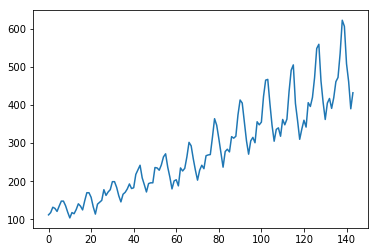

In [25]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [26]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [27]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [28]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [29]:
# Пример подготовленных данных

look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#### Попробуем вначале LSTM состоящую из 4х ячеек

In [37]:
torch_model = nn.LSTM(input_size=look_back, hidden_size=1, num_layers=4)

loss_func = nn.MSELoss()

def train_test(model, look_back=10, hidden=1):
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    losses = []
    for epoch in range(100):
        for i in range(trainY.shape[0]):
            X = Variable(torch.FloatTensor(trainX[i:i+1]))
            Y = Variable(torch.FloatTensor(trainY[i:i+1]))

            y_pred, _ = model(X)
            loss = loss_func(y_pred, Y)
            losses.append(np.array(loss.data))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    predicts = []
    for i, _ in enumerate(testX):
        x_test = Variable(torch.FloatTensor(testX[i:i+1]))
        y_pred, _ = model(x_test)
        predicts.append(np.array(y_pred.data))

    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(121)
    plt.plot(losses)
    plt.title("Losses, with size of hidden layers {0}".format(hidden))
    plt.legend()
    
    ax2 = fig.add_subplot(122)
    plt.plot(np.array(predicts).reshape(-1))
    plt.plot(testY)
    plt.title("Prediction vs test")
    plt.legend()
    plt.show()

100%|██████████| 100/100 [00:21<00:00,  5.40it/s]
/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


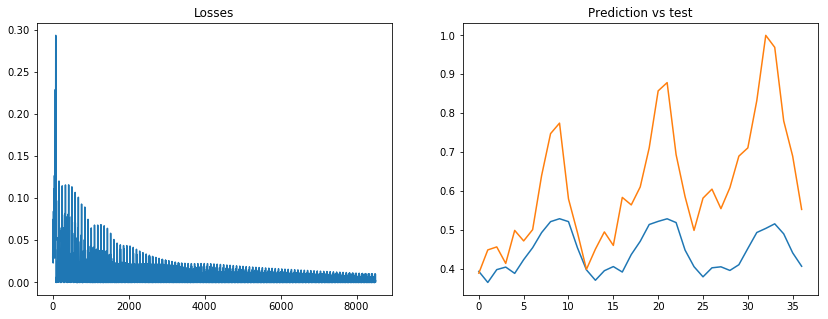

In [71]:
train_test(torch_model)

100%|██████████| 100/100 [00:07<00:00, 14.16it/s]
/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


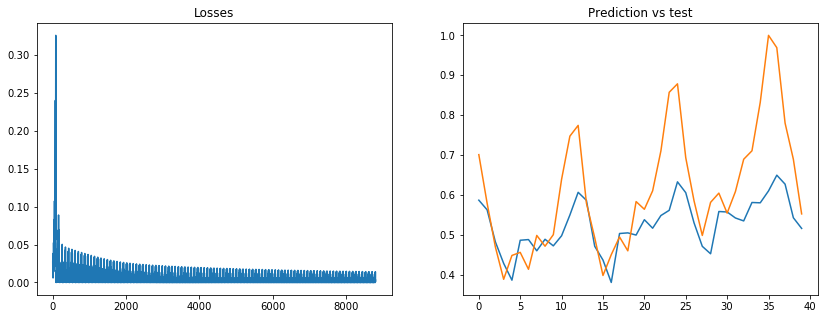

In [73]:
torch_model2 = nn.LSTM(input_size=7, hidden_size=1, num_layers=1)
train_test(torch_model2, look_back=7)

100%|██████████| 100/100 [00:07<00:00, 13.92it/s]
/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


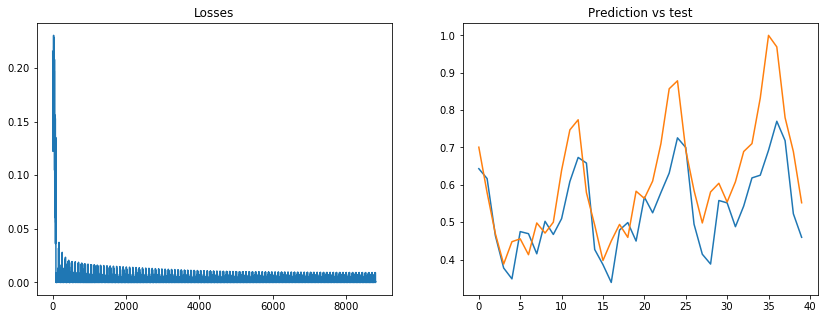

In [75]:
torch_model3 = nn.GRU(input_size=7, hidden_size=1, num_layers=1)      
train_test(torch_model3, look_back=7)

In [ ]:
torch_model3 = nn.GRU(input_size=7, hidden_size=1, num_layers=1)      
train_test(torch_model3, look_back=7)

 49%|████▉     | 49/100 [00:10<00:09,  5.24it/s]

100%|██████████| 100/100 [00:07<00:00, 12.90it/s]
/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


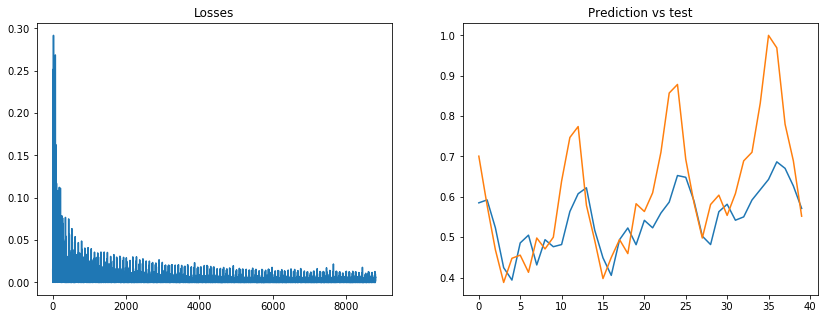

In [52]:
my_model = LSTM(input_size=7, hidden_size=1)
train_test(my_model, look_back=7)

#### Попробую разные размеры скрытого слоя

GRU:

100%|██████████| 100/100 [01:08<00:00,  1.45it/s]
/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


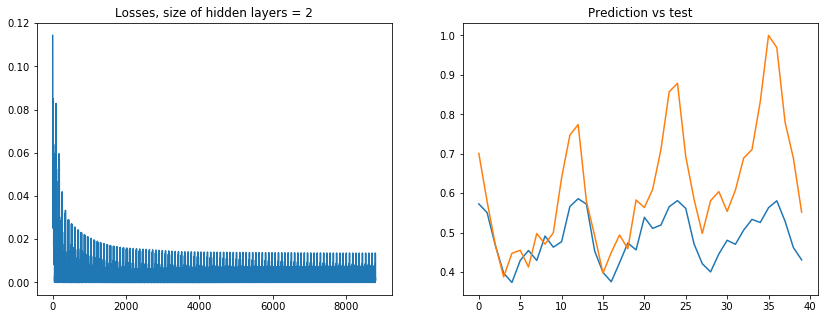

100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


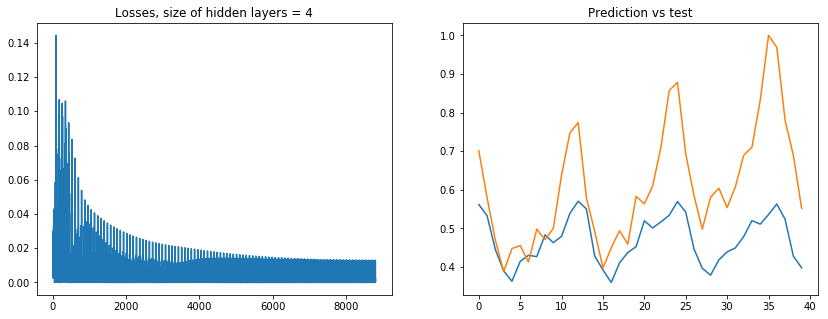

In [28]:
for i in range(2, 6, 2):
    torch_gru = nn.GRU(input_size=7, hidden_size=1, num_layers=i)
    train_test(torch_gru, look_back=7, hidden=i)

LSTM:

/home/ivan.ustinov/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


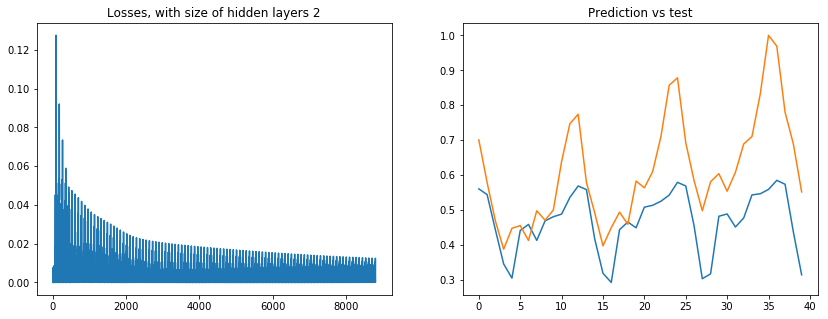

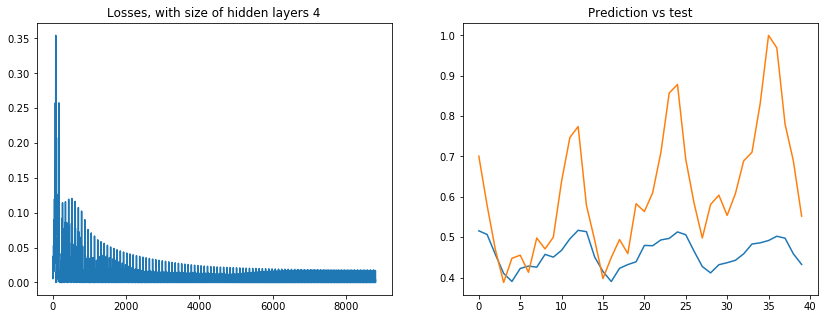

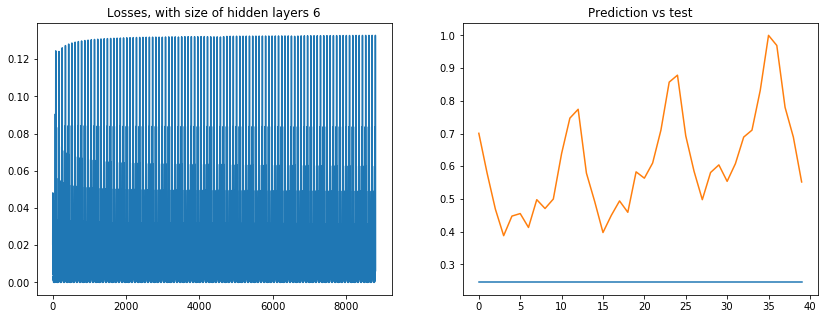

In [38]:
for i in range(2, 8, 2):
    torch_gru = nn.LSTM(input_size=7, hidden_size=1, num_layers=i)
    train_test(torch_gru, look_back=7, hidden=i)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: